## Aims and overview

This is a notebook attempting to more throughly justify and document a response to the followig reviewer comment:

>The only true contribution of the paper in terms of approximating the solution to TSGs is the hybrid proxy, which is rather uninteresting. It is simply a weighted average of the Shapley value of the nested-moat packing approximation of the TSP, and the distance from the depot. Moreover, from the tables it seems like it usually performs slightly worse (although at times slightly better) than one or the other of the two proxies from which it was created.

>What is most concerning, however, is that the experimental results of the authors are questionable. The weights for hybrid proxy were chosen experimentally, which I understand to mean "in order to fit the data." It is unclear whether such a choice for the weights would hold for other experimental data (i.e. data for which the weights were not tailored). For meaningful results and a proper evaluation of the hybrid proxy, cross-validation would be necessary.

We are working under the following hypothsis: **A linear blend of one or more of the simple to compute proxies can give us errors that are on par with using the more complicated ApproShapley approximation.**

As this is a linear model we do not have any hyperparameters that we need to train.  Hence simple cross-validation on the set of Euclidian instances is sufficient to prove that the model has predictive power. 

We assume no knolwdge about the other locations on the route, hence as training data we can use all tuples made up of (Shapley Value, Christo, Distance, Moat, Shortcut, Reroute).  We are attempting to predict Shapley Value more accuratly than Christo. using a subset of rest of the order.

Let's load up the data and shape it down into a nice format.

In [2]:
## Setup and import

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import glob
matplotlib.style.use('bmh')
%matplotlib inline

font = {'size'   : 20}

matplotlib.rc('font', **font)

### Import and make dataset in memory...

__FNAME_STRING = "/merged_raw_samples-s"
__INPUT_DIRECTORY = "../../Euclidean-TSP-Results/merged/"
__N_LOCATIONS = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

#parse off the data...
def parse_file(inf):
    ''' Parse info for the RAW Files... 
    Recs are:
    4 0 0 0 0 0 0
    4 612.674 449.554 184.446 196.4 1621.71 98.8617
    4 670.715 480.612 1273.9 280.7 1979.6 178.947
    4 696.214 1109.33 119.401 1502.5 1979.6 819.503

    The fields are:
    (0) The number of customers (including depot)
    (1) ApproShapley Approx (1K iters) with Concorde for TSP solution
    (2) ApproShapley Approx (1K iters) with Christofedias Tree approx for TSP solution
    (3) Shortcut Allocation (keeping the TSP solution for the grand tour, delete a customer and charge them the delta in the tour cost while keeping all the routes the same (simply skipping agent i in the tour).)
    (4) Moat Packing allocation
    (5) Reroute Marginal Allocation (delete customer i and then re-compute the optimal route.  Charging the deleted customer the delta in cost from the optimal route with i to the optimal route without i.)
    (6) Depot distance
    
    Here we only need to keep (2), (5), (7) as we are optimizing a combo of 5,7 to predict 2.

    '''
    ### Here we only need 2, 5, and 7 and it's completely independent 
    ### But we have to normalize over the sum of the values.
    
    data = []
    
    fin = inf.readlines()
    while len(fin) > 0:
        number_of_locations = int(fin[0].split(" ")[0].strip())
        #Throw out depot line..
        fin.pop(0)
        nloc = []
        svs = []
        moats = []
        dists = []
        short = []
        reroute = []
        for i in range(number_of_locations - 1):
            #Break Up an Entry...
            clocation = fin.pop(0)
            bits = clocation.strip().split(" ")
            nloc.append(int(bits[0]))
            svs.append(float(bits[1]))
            moats.append(float(bits[4]))
            dists.append(float(bits[6]))
            short.append(float(bits[3]))
            reroute.append(float(bits[5]))

        #Normalize each by the sum and append the tuple to the data...
        for c, v in enumerate(svs):
            tup = (svs[c] / sum(svs), nloc[c], moats[c] / sum(moats), dists[c] / sum(dists), \
                   short[c] / sum(short), reroute[c] / sum(reroute))
            data.append(tup)
    return data
  

# Build Dataset ---> Tuple with (Distance, Moat, Shapley)
dataset = []
for c_sample_num in __N_LOCATIONS:
    data_files = glob.glob(__INPUT_DIRECTORY + __FNAME_STRING + \
        str(c_sample_num) + "*")
    for s in data_files:
        with open(s, 'r') as input_file:
            dataset += parse_file(input_file)

#Convert to PANDAS style
df = pd.DataFrame(dataset, columns=['shapley', 'nloc', 'moat', 'distance', 'short', 'reroute'])
print(df[:5])
#Shuffle the data around as it's ordered currently.
df = df.reindex(np.random.permutation(df.index))
print(df[:5])



    shapley  nloc      moat  distance     short   reroute
0  0.257929     5  0.108350  0.290139  0.608074  0.097509
1  0.257978     5  0.329075  0.250484  0.008615  0.290019
2  0.285090     5  0.503950  0.200951  0.098180  0.603916
3  0.199003     5  0.058625  0.258427  0.285130  0.008556
4  0.291565     5  0.508122  0.236742  0.675949  0.675400
         shapley  nloc      moat  distance     short   reroute
115097  0.057195    16  0.042372  0.079176  0.004750  0.025295
8853    0.241797     6  0.299590  0.298050  0.267551  0.320570
36214   0.093988    10  0.050913  0.130726  0.019147  0.002330
51689   0.103415    11  0.039119  0.161650  0.068692  0.052173
137321  0.048134    17  0.011298  0.080494  0.008702  0.017436


## Model Selection

To justify the notion that a linear model can recapture the data I ran the data through a PCA to see if we could find any interesting meta features (not likely because the items are so highly correlated).  Below what we are seeing is that we only need a 1D model to explain ~99% of the variance.  This means that if we were to feed all the columns in together we could almost recover the Shapley Value.

** Conclusion: It is reasonable to use a linear model in this setting. **

In [3]:
### Exploration with a PCA decomp.
from sklearn import decomposition

pca = decomposition.PCA()
data = df.loc[:, ['nloc', 'moat', 'distance', 'short', 'reroute']]
target = df.loc[:, ['shapley']]

pca.fit(data)

plt.figure(1, figsize=(12, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.title("PCA Decomposition - Synthetic Dataset")
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.xticks([0, 1, 2, 3, 4])
plt.ylim(0,1.0)

print(pca.explained_variance_ratio_)
plt.savefig('pca.png',bbox_inches='tight')

[  9.98535828e-01   7.68256013e-04   5.74697924e-04   7.75021983e-05
   4.37156512e-05]


## Feature Selection
Now that we've settled that a linear model can be a good thing for this setting we need to decide on which features to include in said model.  Below we use SciKit to preform k-best feature selection which looks at each one of the possible features in turn and gives us a score for each (univariate feature selection using ANOVA).  Below you'll see that distance has a score of 1 (most important and suppper correlated) and that moat has the second highest score.

**Conclusion: It is reasonable to select only the Moat and Distance they are the most significantly correlated with the output values.**

In [47]:
# Try to just do feature selection...

data = df.loc[:, ['nloc', 'moat', 'distance', 'short', 'reroute']]
target = df.loc[:, ['shapley']]
print(data[:5])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
data.shape
target.shape

selection = SelectKBest(f_regression, k=3)
data = selection.fit_transform(data, list(target['shapley']))
print(selection.scores_ / selection.scores_.max())
print(selection.pvalues_)

        nloc      moat  distance     short   reroute
15340      7  0.043312  0.106373  0.002620  0.002051
203430    21  0.051239  0.054330  0.099739  0.047028
71603     13  0.015622  0.101659  0.265210  0.010380
770        5  0.102760  0.245859  0.020353  0.020353
113755    16  0.014775  0.094167  0.045306  0.000877
[ 0.27072471  0.6305118   1.          0.02603689  0.49458671]
[ 0.  0.  0.  0.  0.]


## Learning the Model and Cross-Validation

Now that we have some candidate models (we will check a couple different ones here) we want to make sure we are not overfitting the data. To do this we will use all the Euclidian data and perform 10 fold cross validation and startified k-fold sampling (so target set has the same statistical makeup as the source set).  We will run this through for our proposed model of DISTANCE + MOAT and then a couple others just to see how we go.

R2 Scoring Mean: 0.882499772477 STD: 0.00251843617178


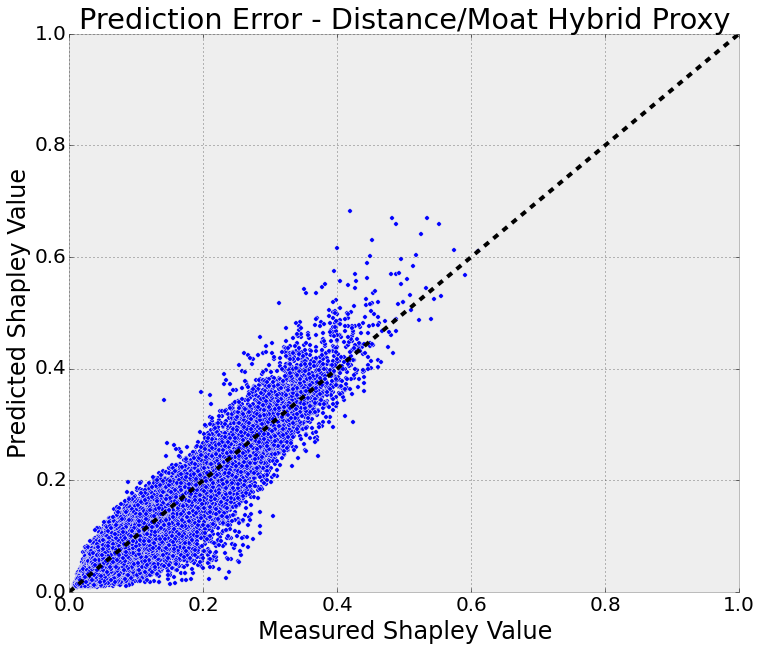

In [51]:
#Use cross validate to check on everything.

from sklearn import cross_validation
from sklearn import metrics
from sklearn import linear_model

#Create data and target sets.
data_1 = df.loc[:, ['distance', 'moat']]
data_2 = df.loc[:, ['distance', 'reroute']]
data_3 = df.loc[:, ['distance', 'moat', 'reroute', 'short', 'nloc']]

target = df.loc[:, ['shapley']]

# Using 10 fold cross validation and startified k-fold sampling (so target is the same set).
scores = cross_validation.cross_val_score(linear_model.LinearRegression(), data_1, target,scoring='r2', cv=10)
predicted = cross_validation.cross_val_predict(linear_model.LinearRegression(), data_1, target, cv=10)
fig,ax = plt.subplots(figsize=(12, 10))
ax.scatter(target, predicted)
ax.plot([0.0, 1.0], [0.0, 1.0], 'k--', lw=4)
ax.set_xlabel('Measured Shapley Value')
ax.set_ylabel('Predicted Shapley Value')
ax.set_title("Prediction Error - Distance/Moat Hybrid Proxy")
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 1.0)
fig.show()
plt.savefig('prediction_error.png',bbox_inches='tight')
print("R2 Scoring Mean: " + str(scores.mean()) + " STD: " + str(scores.std()))

# scores = cross_validation.cross_val_score(linear_model.LinearRegression(), data_2, target,scoring='r2', cv=10)
# predicted = cross_validation.cross_val_predict(linear_model.LinearRegression(), data_2, target, cv=10)
# fig,ax = plt.subplots()
# ax.scatter(target, predicted)
# ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=4)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# ax.set_title("using distance,reroute " + "Mean: " + str(scores.mean()) + " :: " + "StDev: " + str(scores.std()))
# fig.show()

# scores = cross_validation.cross_val_score(linear_model.LinearRegression(), data_3, target, scoring='r2', cv=10)
# predicted = cross_validation.cross_val_predict(linear_model.LinearRegression(), data_3, target, cv=10)
# fig,ax = plt.subplots()
# ax.scatter(target, predicted)
# ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=4)
# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# ax.set_title('using distance,moat,reroute ' + "Mean R2" + str(scores.mean()) + " :: " + "StDev: " + str(scores.std()))
# fig.show()

### Final Model and Parameters
From the above we can see that each of the models are fairly robust to cross-validation so we can go ahead and say that these are good models.  The Distance+Reroute model is actually slightly better, overall, than the MOAT+DIST.  However, we can compute the Moat allocation faster and so we want to use this model.  For practical purposes they are indisguinshable on the test datasets (.000367 v. .000324 for mean squared error as a scoring metric).

Hence we can compute the final model parameters below to include in the paper and use in the evaluation in the other paper.


In [49]:
#Create data and target sets.
data = df.loc[:, ['distance', 'moat']]
target = df.loc[:, ['shapley']]

lr = linear_model.LinearRegression()
lr.fit(data, target)
print("Using: Distance,Moat")
print("Coeffs: " + str(lr.coef_))
print("Intercept: " + str(lr.intercept_))
#print("Model Coeffs: " + str(lr.get_params)


Using: Distance,Moat
Coeffs: [[ 0.57852479  0.31783307]]
Intercept: [ 0.00863684]
